In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [2]:
# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transforms and loaders
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Load MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)  # Adjust for CIFAR-10 (10 classes)
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Define training and evaluation functions
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100 * correct / total
    return running_loss / len(loader.dataset), accuracy

# Optimizer schemes
optimizers = {
    "SGD": optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4),
    "Adam": optim.Adam(model.parameters(), lr=0.001),
    "CosineAnnealing": optim.Adam(model.parameters(), lr=0.001)
}
schedulers = {
    "SGD": optim.lr_scheduler.StepLR(optimizers["SGD"], step_size=10, gamma=0.1),
    "CosineAnnealing": optim.lr_scheduler.CosineAnnealingLR(optimizers["CosineAnnealing"], T_max=20)
}

C:\Users\Stewie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Stewie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Training loop
num_epochs = 20
results = {}
for name, optimizer in optimizers.items():
    print(f"Training with {name} optimizer")
    train_losses, test_losses, test_accuracies = [], [], []
    scheduler = schedulers.get(name, None)
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer)
        test_loss, test_accuracy = evaluate(model, test_loader, criterion)
        if scheduler:
            scheduler.step()
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f"{name} - Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    results[name] = (train_losses, test_losses, test_accuracies)

Training with SGD optimizer
SGD - Epoch [1/20], Train Loss: 1.2408, Test Loss: 0.8925, Test Accuracy: 68.85%
SGD - Epoch [2/20], Train Loss: 0.8221, Test Loss: 0.7406, Test Accuracy: 73.90%
SGD - Epoch [3/20], Train Loss: 0.7114, Test Loss: 0.6697, Test Accuracy: 76.82%
SGD - Epoch [4/20], Train Loss: 0.6544, Test Loss: 0.6502, Test Accuracy: 77.30%
SGD - Epoch [5/20], Train Loss: 0.6115, Test Loss: 0.6853, Test Accuracy: 76.03%
SGD - Epoch [6/20], Train Loss: 0.5854, Test Loss: 0.6184, Test Accuracy: 78.75%
SGD - Epoch [7/20], Train Loss: 0.5621, Test Loss: 0.6043, Test Accuracy: 78.78%
SGD - Epoch [8/20], Train Loss: 0.5549, Test Loss: 0.5817, Test Accuracy: 79.64%
SGD - Epoch [9/20], Train Loss: 0.5245, Test Loss: 0.5618, Test Accuracy: 80.55%
SGD - Epoch [10/20], Train Loss: 0.5129, Test Loss: 0.5684, Test Accuracy: 80.45%
SGD - Epoch [11/20], Train Loss: 0.4227, Test Loss: 0.4711, Test Accuracy: 83.85%
SGD - Epoch [12/20], Train Loss: 0.3873, Test Loss: 0.4570, Test Accuracy: 84.5

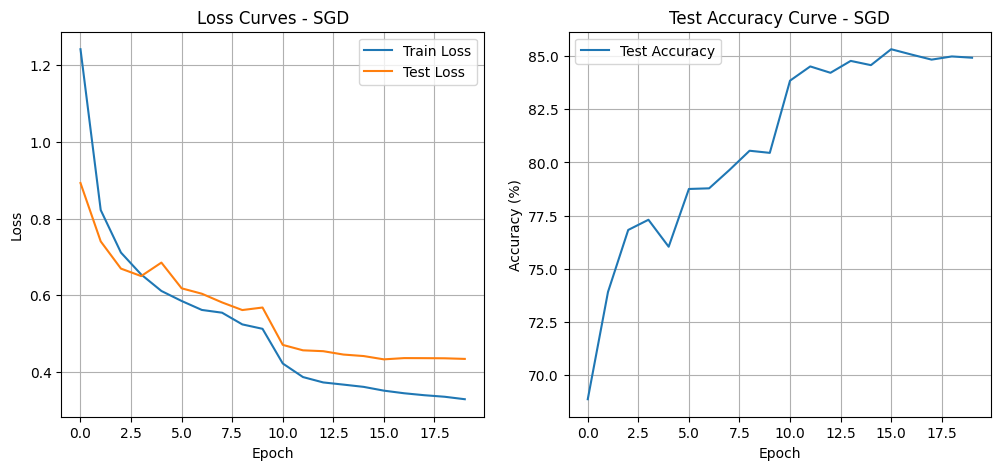

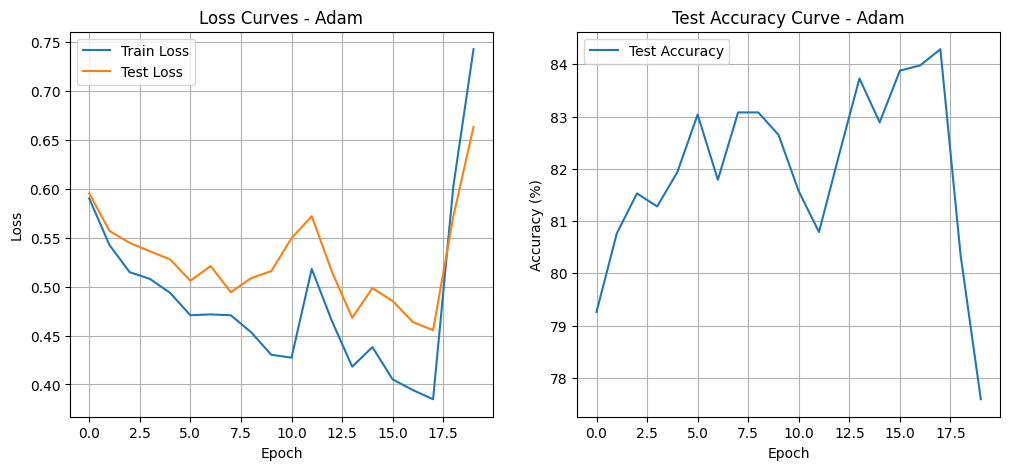

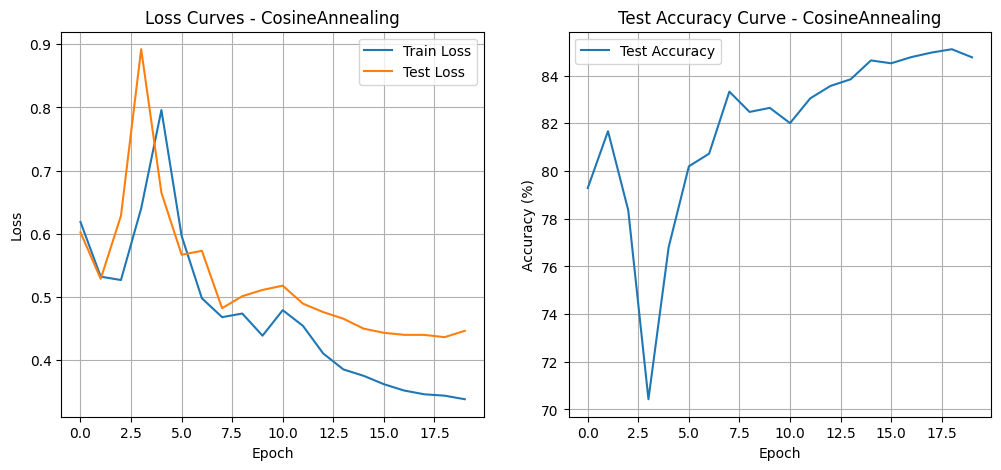

In [5]:
# Plot results
for name, (train_losses, test_losses, test_accuracies) in results.items():
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curves - {name}')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Test Accuracy Curve - {name}')
    plt.legend()
    plt.grid(True)
    
    plt.show()
